# DDQN aplicado al entorno de Lunar Lander v2 (OpenAI-gym)

In [6]:
import gym

import random
import numpy as np
from collections import deque

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import matplotlib as mpl

from time import time

### Definir la clase del agente

In [7]:
class DDQNAgent:
    def __init__(self, state_size, action_size, gamma, lr, ep_dec):
        self.state_size = state_size      
        self.action_size = action_size     
        self.memory = deque(maxlen=4000)  
        self.gamma = gamma                 
        self.learning_rate = lr         
        
        self.epsilon = 1.0               
        self.epsilon_min = 0.01          
        self.epsilon_decay = ep_dec      
        self.model = self._build_model() 
           
        self.target_model = self._build_model() 
        self.update_target_model() 
       

    def _build_model(self):
        
        model = Sequential()   
        model.add(Dense(25, input_dim=self.state_size, activation='relu')) 
        model.add(Dense(20, activation='relu')) 
        model.add(Dense(self.action_size, activation='linear'))
        
        model.compile(loss='mse', optimizer = Adam(lr=self.learning_rate))
        return model
    
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done): 
        self.memory.append((state, action, reward, next_state, done))

    def get_action(self, state):
        if np.random.rand() <= self.epsilon:  
            return random.randrange(self.action_size)
        action_values = self.model.predict(state) 
        return np.argmax(action_values[0])  

    def replay(self, batch_size): 
        minibatch = random.sample(self.memory, batch_size) 
        
        states = np.array([i[0] for i in minibatch])    
        actions = np.array([i[1] for i in minibatch])   
        rewards = np.array([i[2] for i in minibatch])   
        next_states = np.array([i[3] for i in minibatch]) 
        dones = np.array([i[4] for i in minibatch])       
        states = np.squeeze(states)
        next_states = np.squeeze(next_states)
        
       
        Qvals_next_states = self.target_model.predict_on_batch(next_states)  
        Targets_actions = rewards + self.gamma*(np.amax(Qvals_next_states, axis=1))*(1-dones)
              
        Targets = self.model.predict_on_batch(states)  
        ind = np.array([i for i in range(batch_size)])
        Targets[[ind], [actions]] = Targets_actions   
        
        
        self.model.fit(states, Targets, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min: 
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)


### Definir los hiperparametros 

In [8]:
done = False
batch_size = 128
EPISODES = 200
GAMMA=0.99
LEARNING_RATE=0.0008
EP_DEC=0.998

### Declaramos el entorno, el agente y otras variables

In [9]:
env = gym.make('LunarLander-v2')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DDQNAgent(state_size, action_size, GAMMA, LEARNING_RATE, EP_DEC)  

score_list = []     
epsilon_list = []

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Ejecutar el agente en el entorno LunarLander 

In [46]:
start_time = time()
for e in range(EPISODES):  
    state = env.reset()    
    state = np.reshape(state, [1, state_size])
    score = 0
    acc_s = 0
    for step in range(500):  
        #env.render()
        action = agent.get_action(state)   
        next_state, reward, done, _ = env.step(action)  
        acc_s+=reward
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done) 
        state = next_state   
        
        
        if len(agent.memory) > batch_size:  
            agent.replay(batch_size)
        
        if done:  # si es estado terminal
            print("episode: {}/{}, score: {}, e: {:.2}".format(e, EPISODES, acc_s, agent.epsilon))
            break
            
    agent.update_target_model() 
    score_list.append(acc_s)   
    epsilon_list.append(agent.epsilon)
        
env.close()
print(time()-start_time)

episode: 0/200, score: -168.88276456147466, e: 1.0
episode: 1/200, score: -106.48681528953198, e: 0.85
episode: 2/200, score: -85.24568268163482, e: 0.76
episode: 3/200, score: -101.1811540947342, e: 0.6
episode: 4/200, score: -316.86732002841256, e: 0.52
episode: 5/200, score: -111.75277163893635, e: 0.42
episode: 6/200, score: -306.38044119471397, e: 0.34
episode: 7/200, score: -295.5942227247076, e: 0.28
episode: 8/200, score: -32.27891342892558, e: 0.2
episode: 9/200, score: -17.832074978786267, e: 0.15
episode: 10/200, score: -309.9322667242112, e: 0.12
episode: 13/200, score: -86.54188075886725, e: 0.011
episode: 14/200, score: -212.33985158132288, e: 0.01
episode: 15/200, score: -26.426146217034514, e: 0.01
episode: 16/200, score: -58.84655825976489, e: 0.01
episode: 17/200, score: -273.729666858595, e: 0.01
episode: 18/200, score: -110.9035701379744, e: 0.01
episode: 19/200, score: -56.00603125691204, e: 0.01
episode: 20/200, score: -70.27698363241572, e: 0.01
episode: 21/200, 

### Graficando resultados

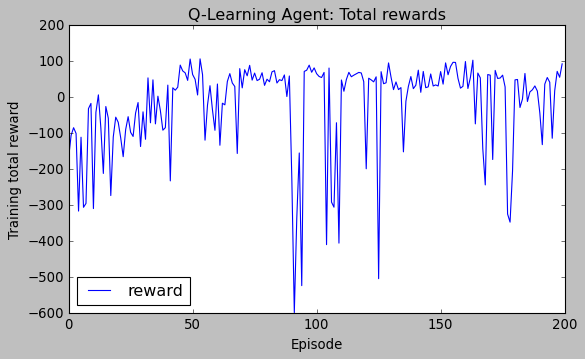

In [47]:
fig, ax = plt.subplots(figsize=(8, 4.5))
mpl.style.use('classic')
ax.set_title('Q-Learning Agent: Total rewards')
ax.set_xlabel('Episode')
#ax.set_xlim(-1000,20000)
ax.set_ylabel('Training total reward')
ax.plot(score_list,'-', label='reward')
ax.legend(loc='best')

### Probando el agente entrenado  en el entorno LunarLander 

In [10]:
def play_LunarLander(agent, trials = 1):
    env = gym.make('LunarLander-v2')

    scores = []
    for trial in range(trials):
        score = 0
        game_memory = []
        state = []
        env.reset()
        for step in range(500):
            env.render()

            if len(state) == 0:    
                action = random.randrange(0,4)
            else:
                action_values = agent.model.predict(state.reshape(1, 8)) 
                action = np.argmax(action_values[0])      

            next_state, reward, done, _  = env.step(action)  
            score += reward
            state = next_state
            game_memory.append([next_state, action])
            if done: 
                #print("Play {}/{}, score: {}".format(trial, trials, step))
                break
        print("Play {}/{}, score: {}".format(trial, trials, score))
        scores.append(score)
    env.close()
 
    print("Score medio = {}".format(sum(scores) /float(trials)) )

In [11]:
play_LunarLander(agent,5)

Play 0/5, score: -708.5540775432747
Play 1/5, score: -684.1600477907963
Play 2/5, score: -797.8913528404065
Play 3/5, score: -643.4858926724272
Play 4/5, score: -668.7274898698647
Score medio = -700.5637721433538
